# **Steam video game recommendation**

In [ ]:
import urllib
import pandas as pd
import re
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import statistics
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler

In [ ]:
steam_data = pd.read_csv('https://raw.githubusercontent.com/abystoma/steam-recommender/main/steam.csv')

In [ ]:
steam_data.isna().sum()

appid               0
name                0
release_date        0
english             0
developer           0
publisher           0
platforms           0
required_age        0
categories          0
genres              0
steamspy_tags       0
achievements        0
positive_ratings    0
negative_ratings    0
average_playtime    0
median_playtime     0
owners              0
price               0
dtype: int64

In [ ]:
steam_data.genres.unique().shape[0], steam_data.platforms.unique().shape[0], steam_data.categories.unique().shape[0], steam_data.steamspy_tags.unique().shape[0] 

(1552, 7, 3333, 6423)

In [ ]:
steam_data

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1065230,Room of Pandora,2019-04-24,1,SHEN JIAWEI,SHEN JIAWEI,windows,0,Single-player;Steam Achievements,Adventure;Casual;Indie,Adventure;Indie;Casual,7,3,0,0,0,0-20000,2.09
27071,1065570,Cyber Gun,2019-04-23,1,Semyon Maximov,BekkerDev Studio,windows,0,Single-player,Action;Adventure;Indie,Action;Indie;Adventure,0,8,1,0,0,0-20000,1.69
27072,1065650,Super Star Blast,2019-04-24,1,EntwicklerX,EntwicklerX,windows,0,Single-player;Multi-player;Co-op;Shared/Split ...,Action;Casual;Indie,Action;Indie;Casual,24,0,1,0,0,0-20000,3.99
27073,1066700,New Yankee 7: Deer Hunters,2019-04-17,1,Yustas Game Studio,Alawar Entertainment,windows;mac,0,Single-player;Steam Cloud,Adventure;Casual;Indie,Indie;Casual;Adventure,0,2,0,0,0,0-20000,5.19


# PREPROCESSING

## Finding Median of owners


In [ ]:
assessments = []
for string in steam_data.owners:
    tmp_owner = string.split("-")
    total = (int(tmp_owner[0]) + int(tmp_owner[1]))/2
    assessments.append(int(total))

steam_data['owners'] = assessments

## Working with genres


In [ ]:
genres = []
for string in steam_data.genres.unique():
    tmp_genres = string.split(";")
    for genre in tmp_genres:
        if genre not in genres:
            genres.append(genre)

genres

['Action',
 'Free to Play',
 'Strategy',
 'Adventure',
 'Indie',
 'RPG',
 'Animation & Modeling',
 'Video Production',
 'Casual',
 'Simulation',
 'Racing',
 'Violent',
 'Massively Multiplayer',
 'Nudity',
 'Sports',
 'Early Access',
 'Gore',
 'Utilities',
 'Design & Illustration',
 'Web Publishing',
 'Education',
 'Software Training',
 'Sexual Content',
 'Audio Production',
 'Game Development',
 'Photo Editing',
 'Accounting',
 'Documentary',
 'Tutorial']

In [ ]:
steam_data = steam_data.reindex(columns=list(steam_data.columns)+genres)


In [ ]:
ids = steam_data.index

for i, string in zip(ids, steam_data.genres):
    tmp_genres = string.split(";")
    for genre in genres:
        if genre  in tmp_genres:
            steam_data.at[i, genre] = 1
        else :
            steam_data.at[i, genre] = 0


steam_data.drop(columns="genres", axis=1, inplace=True)

In [ ]:
for genre in genres:
    steam_data[genre] = pd.to_numeric(steam_data[genre], downcast="integer")

steam_data

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,steamspy_tags,...,Web Publishing,Education,Software Training,Sexual Content,Audio Production,Game Development,Photo Editing,Accounting,Documentary,Tutorial
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action;FPS;Multiplayer,...,0,0,0,0,0,0,0,0,0,0
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action;FPS;Multiplayer,...,0,0,0,0,0,0,0,0,0,0
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,FPS;World War II;Multiplayer,...,0,0,0,0,0,0,0,0,0,0
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action;FPS;Multiplayer,...,0,0,0,0,0,0,0,0,0,0
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,FPS;Action;Sci-fi,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1065230,Room of Pandora,2019-04-24,1,SHEN JIAWEI,SHEN JIAWEI,windows,0,Single-player;Steam Achievements,Adventure;Indie;Casual,...,0,0,0,0,0,0,0,0,0,0
27071,1065570,Cyber Gun,2019-04-23,1,Semyon Maximov,BekkerDev Studio,windows,0,Single-player,Action;Indie;Adventure,...,0,0,0,0,0,0,0,0,0,0
27072,1065650,Super Star Blast,2019-04-24,1,EntwicklerX,EntwicklerX,windows,0,Single-player;Multi-player;Co-op;Shared/Split ...,Action;Indie;Casual,...,0,0,0,0,0,0,0,0,0,0
27073,1066700,New Yankee 7: Deer Hunters,2019-04-17,1,Yustas Game Studio,Alawar Entertainment,windows;mac,0,Single-player;Steam Cloud,Indie;Casual;Adventure,...,0,0,0,0,0,0,0,0,0,0


## Working with platforms


In [ ]:
np.unique(steam_data['platforms'])


array(['linux', 'mac', 'mac;linux', 'windows', 'windows;linux',
       'windows;mac', 'windows;mac;linux'], dtype=object)

In [ ]:
steam_platforms = steam_data['platforms'].str.get_dummies(';')
steam_data = steam_data.join(steam_platforms)
steam_data = steam_data.drop(columns=['platforms'])
steam_data.head()

,appid,name,release_date,english,developer,publisher,required_age,categories,steamspy_tags,achievements,...,Sexual Content,Audio Production,Game Development,Photo Editing,Accounting,Documentary,Tutorial,linux,mac,windows
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,0,Multi-player;Online Multi-Player;Local Multi-P...,Action;FPS;Multiplayer,0,...,0,0,0,0,0,0,0,1,1,1
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,0,Multi-player;Online Multi-Player;Local Multi-P...,Action;FPS;Multiplayer,0,...,0,0,0,0,0,0,0,1,1,1
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,0,Multi-player;Valve Anti-Cheat enabled,FPS;World War II;Multiplayer,0,...,0,0,0,0,0,0,0,1,1,1
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,0,Multi-player;Online Multi-Player;Local Multi-P...,Action;FPS;Multiplayer,0,...,0,0,0,0,0,0,0,1,1,1
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,0,Single-player;Multi-player;Valve Anti-Cheat en...,FPS;Action;Sci-fi,0,...,0,0,0,0,0,0,0,1,1,1


## Encoding developer, categories, tags and publishers

In [ ]:
steam_data[['developer','categories','steamspy_tags','publisher']] = OrdinalEncoder(dtype = np.int64).fit_transform(steam_data[['developer','categories','steamspy_tags','publisher']])


## Ratings

Joining the positive_ratings and negative_ratings columns into one, which will be expressed as a percentage. Also, I will only select the games that have more ratings (quantity) than 100 (this number can be changed)

Example: If the game has 70 upvotes and 30 downvotes, the new column will have "70" as its value.

In [ ]:
steam_data['total_ratings'] = (steam_data['positive_ratings'] + steam_data['negative_ratings'])


pr = steam_data['positive_ratings']
nr = steam_data['negative_ratings']
ratings = pr+nr

#Selecting only the lines above X ratings, the value can be changed below
x = 150

ratings = pd.DataFrame(ratings, columns=['ratings'])

steam_data = steam_data.join(ratings['ratings'])
list_av = []

for i in range(len(steam_data)):
    if steam_data['ratings'][i] < x: #change this number 100 if you want to decrease or increase the base
        list_av.append(i)

steam_data = steam_data.drop(list_av)

#creating the percentage column

pr = steam_data['positive_ratings']
nr = steam_data['negative_ratings']
ratings = pr+nr

ratings = tuple(ratings)
pr = tuple(pr)

assessments = []

#taking the percentage of 'approval' (positive votes versus negative votes)
for i in range(len(steam_data)):
    res = pr[i] * 100 / ratings[i]
    assessments.append(res)

steam_data = steam_data.drop(columns=['positive_ratings', 'negative_ratings'], axis = 1)

steam_data['ratings'] = assessments

steam_data = steam_data.dropna()

steam_data.head()

,appid,name,release_date,english,developer,publisher,required_age,categories,steamspy_tags,achievements,...,Game Development,Photo Editing,Accounting,Documentary,Tutorial,linux,mac,windows,total_ratings,ratings
0,10,Counter-Strike,2000-11-01,1,15118,12625,0,329,209,0,...,0,0,0,0,0,1,1,1,127873,97.388815
1,20,Team Fortress Classic,1999-04-01,1,15118,12625,0,329,209,0,...,0,0,0,0,0,1,1,1,3951,83.978740
2,30,Day of Defeat,2003-05-01,1,15118,12625,0,497,2532,0,...,0,0,0,0,0,1,1,1,3814,89.564761
3,40,Deathmatch Classic,2001-06-01,1,15118,12625,0,329,209,0,...,0,0,0,0,0,1,1,1,1540,82.662338
4,50,Half-Life: Opposing Force,1999-11-01,1,5659,12625,0,2488,2503,0,...,0,0,0,0,0,1,1,1,5538,94.799567


I will mark the following categories for the evaluations, based on the previous process:

Horrible: ratings < 40%

Bad: 40% <= ratings < 55%

Median: 55% <= ratings < 70%

Good: 70% <= ratings < 90%

Great: ratings >= 90%

In [ ]:
#checking different categories for reviews
steam_data.reset_index(drop=True, inplace=True)
rt = steam_data['ratings']


#basically the following loops will assign different categories to the evaluations, and these categories will be used as the target attribute of the AIs

#transforming ratings into floats numbers and saving to a list
float_ratings = []
for i in range(len(steam_data)):
  float_ratings.append(float(steam_data['ratings'][i]))

rt_temp = []

for i in range(len(steam_data)):

    if float_ratings[i]  < 40:
        rt_temp.append(0)
    elif float_ratings[i] >= 40 and float_ratings[i] < 55:
        rt_temp.append(1)
    elif float_ratings[i] >= 55 and float_ratings[i] < 70:
        rt_temp.append(2)
    elif float_ratings[i] >= 70 and float_ratings[i] < 90:
        rt_temp.append(3)
    elif float_ratings[i] >= 90:
        rt_temp.append(4)

steam_data = steam_data.drop(columns=['ratings'], axis=1)
steam_data['ratings'] = rt_temp


In [ ]:
steam_data['ratings'].value_counts()

3    3638
4    1625
2    1217
1     570
0     245
Name: ratings, dtype: int64

## Working with release data

In [ ]:
now = pd.Timestamp('now')
steam_data['age'] = (now - pd.to_datetime(steam_data['release_date'])).astype('<m8[Y]')
# steam_data = steam_data.drop(columns=['release_date'])
steam_data.head()

,appid,name,release_date,english,developer,publisher,required_age,categories,steamspy_tags,achievements,...,Photo Editing,Accounting,Documentary,Tutorial,linux,mac,windows,total_ratings,ratings,age
0,10,Counter-Strike,2000-11-01,1,15118,12625,0,329,209,0,...,0,0,0,0,1,1,1,127873,4,21.0
1,20,Team Fortress Classic,1999-04-01,1,15118,12625,0,329,209,0,...,0,0,0,0,1,1,1,3951,3,23.0
2,30,Day of Defeat,2003-05-01,1,15118,12625,0,497,2532,0,...,0,0,0,0,1,1,1,3814,3,19.0
3,40,Deathmatch Classic,2001-06-01,1,15118,12625,0,329,209,0,...,0,0,0,0,1,1,1,1540,3,21.0
4,50,Half-Life: Opposing Force,1999-11-01,1,5659,12625,0,2488,2503,0,...,0,0,0,0,1,1,1,5538,4,22.0


# Correlation

In [ ]:
correlations = steam_data.corr()
correlations['ratings']

appid                    0.029963
english                 -0.027222
developer                0.031800
publisher                0.043725
required_age             0.020406
categories               0.142263
steamspy_tags            0.010058
achievements             0.000845
average_playtime         0.022189
median_playtime          0.012610
owners                   0.040368
price                    0.072550
Action                  -0.059098
Free to Play            -0.112447
Strategy                -0.063746
Adventure                0.041421
Indie                    0.100813
RPG                     -0.010470
Animation & Modeling     0.005399
Video Production         0.005877
Casual                   0.052210
Simulation              -0.088551
Racing                  -0.039832
Violent                 -0.037010
Massively Multiplayer   -0.176117
Nudity                   0.015734
Sports                  -0.038141
Early Access            -0.052152
Gore                    -0.040377
Utilities     

In [ ]:
steam_data.drop(['appid','name','release_date','english','Education','achievements','Software Training','Action','Free to Play','Strategy','RPG','Simulation','Racing','Violent','Massively Multiplayer','Sports','Early Access','Utilities','Gore','Audio Production','Game Development','Photo Editing','Accounting','Documentary','Tutorial'], axis = 1, inplace = True)
correlations = steam_data.corr()
correlations['ratings']

developer                0.031800
publisher                0.043725
required_age             0.020406
categories               0.142263
steamspy_tags            0.010058
average_playtime         0.022189
median_playtime          0.012610
owners                   0.040368
price                    0.072550
Adventure                0.041421
Indie                    0.100813
Animation & Modeling     0.005399
Video Production         0.005877
Casual                   0.052210
Nudity                   0.015734
Design & Illustration    0.006172
Web Publishing           0.004869
Sexual Content           0.030641
linux                    0.153267
mac                      0.163024
windows                  0.009528
total_ratings            0.034426
ratings                  1.000000
age                      0.003257
Name: ratings, dtype: float64

# Modelling

## KNN

In [ ]:
X = steam_data.drop('ratings', axis = 1)
y = steam_data['ratings']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
KNNModel = KNeighborsClassifier(n_neighbors=41, weights = 'distance')
                            
KNNModel.fit(X_train, y_train)

predict_train = KNNModel.predict(X_train)
print('Target on train data',predict_train) 
print('accuracy_score on train dataset : ', accuracy_score(y_train,predict_train))

predict_test = KNNModel.predict(X_test)
print('Target on test data',predict_test)
print('accuracy_score on test dataset : ',accuracy_score(y_test,predict_test))

Target on train data [3 2 3 ... 3 2 1]
accuracy_score on train dataset :  1.0
Target on test data [3 3 3 ... 3 3 3]
accuracy_score on test dataset :  0.4970306075833714


In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(KNNModel, X, y,
                         scoring="accuracy",
                         cv=150, n_jobs=-1)

print("Accuracy scores: ", np.round(scores, 2))
print("Average accuracy: ", np.round(np.mean(scores), 2))

Accuracy scores:  [0.49 0.53 0.49 0.51 0.43 0.51 0.57 0.49 0.53 0.51 0.49 0.51 0.51 0.51
 0.53 0.49 0.43 0.43 0.55 0.53 0.55 0.45 0.51 0.47 0.49 0.47 0.51 0.51
 0.45 0.57 0.51 0.47 0.49 0.51 0.45 0.49 0.47 0.49 0.43 0.49 0.47 0.51
 0.49 0.49 0.49 0.53 0.47 0.47 0.49 0.49 0.45 0.51 0.51 0.49 0.47 0.43
 0.49 0.47 0.49 0.51 0.51 0.47 0.47 0.49 0.53 0.49 0.47 0.51 0.45 0.51
 0.51 0.47 0.43 0.43 0.51 0.47 0.45 0.51 0.53 0.53 0.49 0.53 0.49 0.47
 0.45 0.49 0.53 0.49 0.47 0.53 0.51 0.49 0.53 0.49 0.49 0.54 0.48 0.46
 0.54 0.52 0.48 0.54 0.54 0.52 0.42 0.46 0.46 0.48 0.52 0.52 0.48 0.5
 0.5  0.52 0.54 0.5  0.48 0.5  0.42 0.52 0.5  0.44 0.46 0.5  0.58 0.44
 0.54 0.48 0.48 0.58 0.52 0.44 0.46 0.46 0.48 0.52 0.52 0.56 0.44 0.46
 0.48 0.54 0.48 0.48 0.46 0.46 0.6  0.5  0.52 0.52]
Average accuracy:  0.49


2189

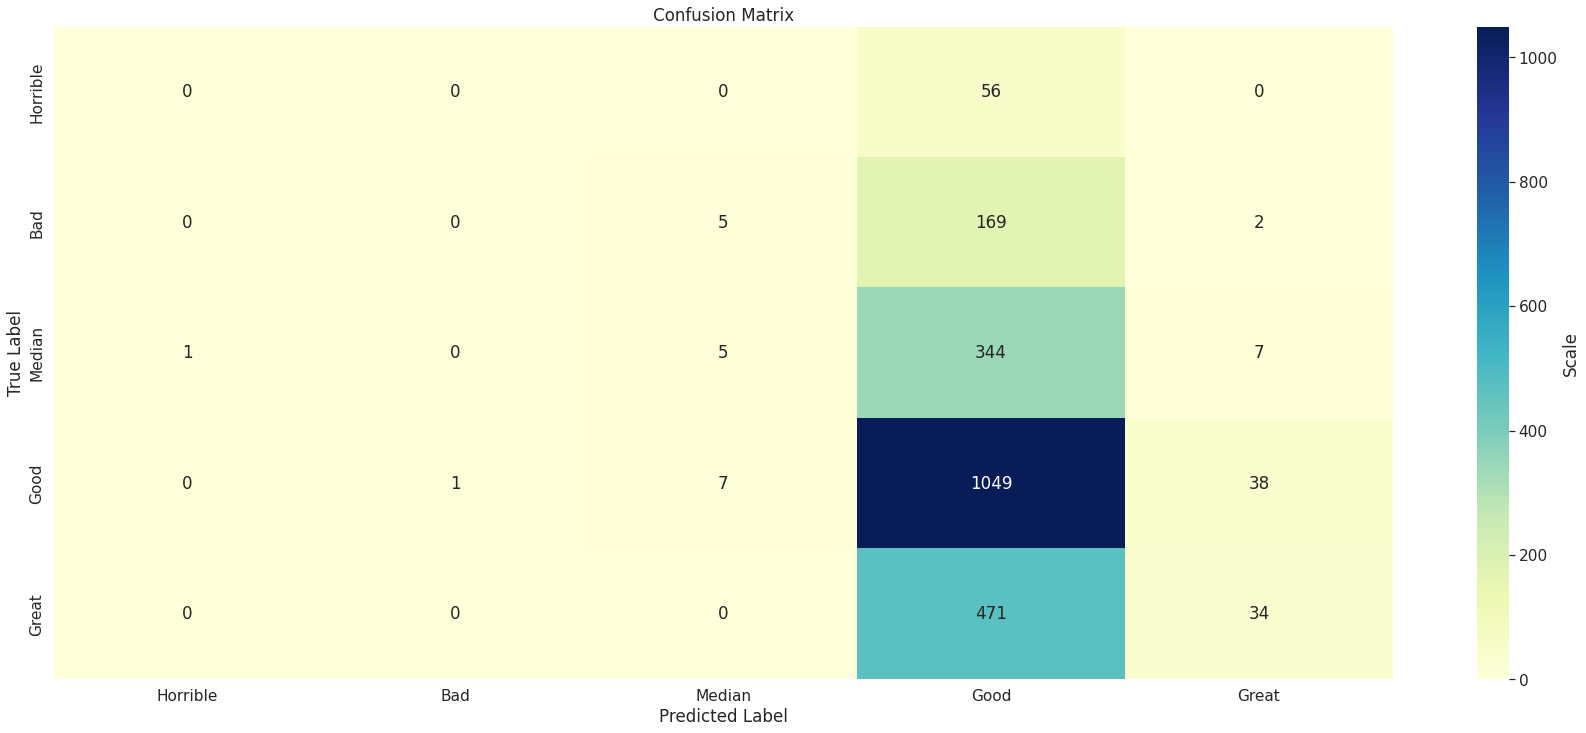

In [ ]:
sb.set(color_codes=True)
sb.set(font_scale=1.4)

plt.figure(1, figsize=(30, 12))
plt.title("Confusion Matrix")
conf_matrix = confusion_matrix(y_test, predict_test)
cm_df = pd.DataFrame(conf_matrix,
                     index = ['Horrible','Bad', 'Median', 'Good', 'Great'], 
                     columns = ['Horrible','Bad', 'Median', 'Good', 'Great'])
train = sb.heatmap(cm_df, annot=True, fmt=".0f",cmap="YlGnBu", cbar_kws={'label': 'Scale'})
train.set(ylabel="True Label", xlabel="Predicted Label")

len(predict_test)

## Decision tree

In [ ]:
# Accuracy is a classification metric. You can't use it with a regression. See the documentation for info on the various metrics.

# Decision Tree using Train Data
X = steam_data.drop(['ratings'], axis = 1)
y = steam_data['ratings']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

dec = DecisionTreeClassifier(max_depth = 100, random_state=50)  # create the decision tree object
dec.fit(X_train, y_train)                    # train the decision tree model


# predict the target on the train dataset
predict_train = dec.predict(X_train)
print('Target on train data',predict_train) 

# Accuray Score on train dataset
accuracy_train = accuracy_score(y_train,predict_train)
print('accuracy_score on train dataset : ', accuracy_train)

# predict the target on the test dataset
predict_test = dec.predict(X_test)
print('Target on test data',predict_test) 


# Accuracy Score on test dataset
nbscore = accuracy_score(y_test,predict_test)
print('accuracy_score on test dataset : ',nbscore)

# Plot the Confusion Matrix for Train and Test

Target on train data [3 3 4 ... 4 3 3]
accuracy_score on train dataset :  1.0
Target on test data [3 3 2 ... 3 3 4]
accuracy_score on test dataset :  0.39561443581544087


In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dec, X, y,
                         scoring="accuracy",
                         cv=50, n_jobs=-1)

print("Accuracy scores: ", np.round(scores, 2))
print("Average accuracy: ", np.round(np.mean(scores), 2))

Accuracy scores:  [0.34 0.4  0.34 0.34 0.45 0.41 0.42 0.47 0.42 0.46 0.42 0.4  0.34 0.38
 0.39 0.46 0.43 0.34 0.41 0.35 0.34 0.47 0.51 0.36 0.37 0.36 0.41 0.44
 0.38 0.4  0.39 0.45 0.3  0.43 0.4  0.36 0.35 0.33 0.45 0.36 0.4  0.32
 0.4  0.34 0.34 0.41 0.29 0.49 0.38 0.41]
Average accuracy:  0.39


2189

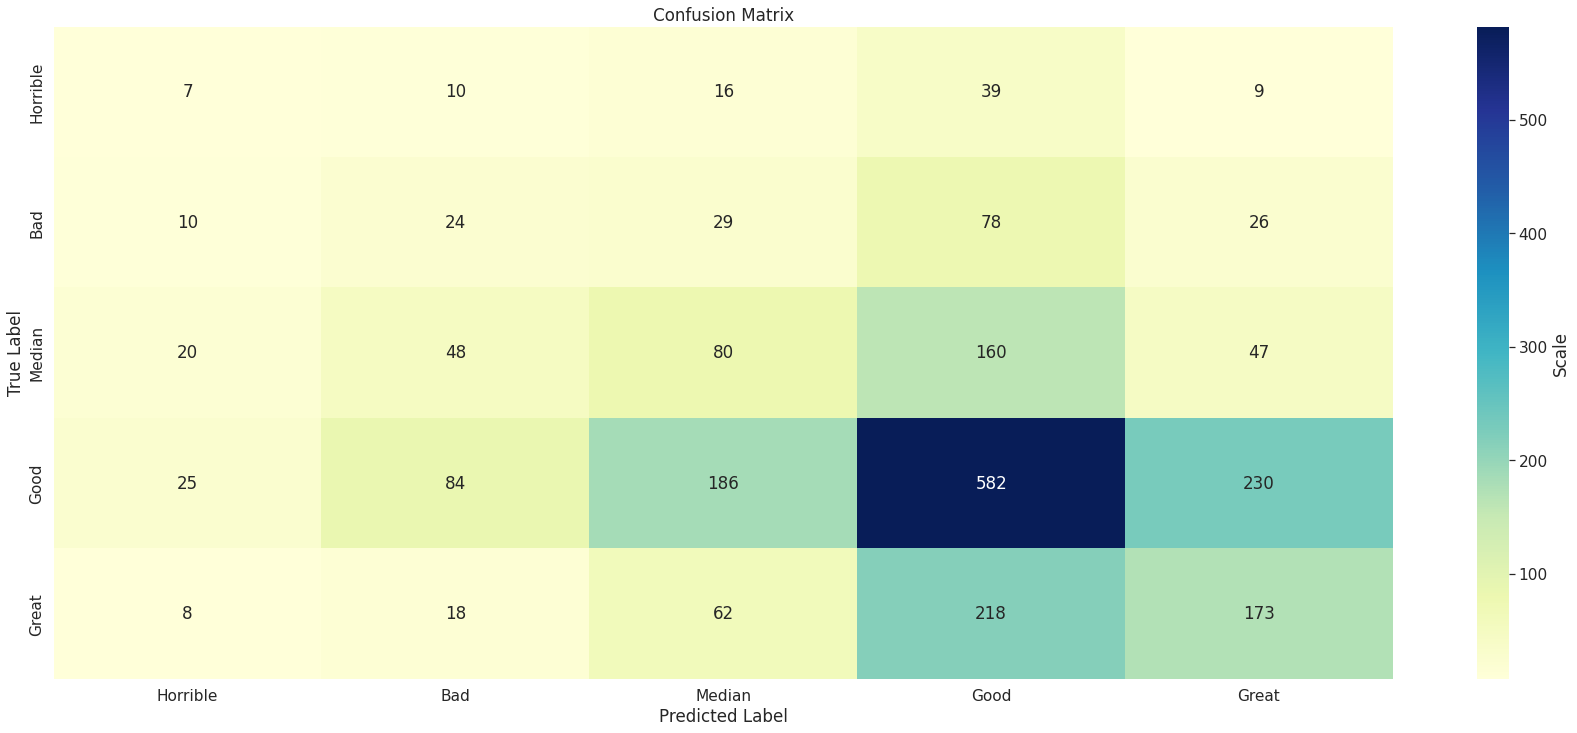

In [ ]:
sb.set(color_codes=True)
sb.set(font_scale=1.4)

plt.figure(1, figsize=(30, 12))
plt.title("Confusion Matrix")
conf_matrix = confusion_matrix(y_test, predict_test)
cm_df = pd.DataFrame(conf_matrix,
                     index = ['Horrible','Bad', 'Median', 'Good', 'Great'], 
                     columns = ['Horrible','Bad', 'Median', 'Good', 'Great'])
train = sb.heatmap(cm_df, annot=True, fmt=".0f",cmap="YlGnBu", cbar_kws={'label': 'Scale'})
train.set(ylabel="True Label", xlabel="Predicted Label")
len(predict_test)

## Random forest

In [ ]:
# Decision Tree using Train Data
X = steam_data.drop(['ratings'], axis = 1)
y = steam_data['ratings']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
# for i in range(1,100):
forest = RandomForestClassifier(n_estimators=80, criterion = 'entropy', random_state=1)  # create the decision tree object
forest.fit(X_train, y_train)                    # train the decision tree model


# predict the target on the train dataset
predict_train = forest.predict(X_train)
# print('Target on train data',predict_train) 

# Accuray Score on train dataset
print('accuracy_score on train dataset : ', accuracy_score(y_train,predict_train),i)

# predict the target on the test dataset
predict_test = forest.predict(X_test)
# print('Target on test data',predict_test) 

# Accuracy Score on test dataset
print('accuracy_score on test dataset : ',accuracy_score(y_test,predict_test))

# Plot the Confusion Matrix for Train and Test

accuracy_score on train dataset :  1.0 7294
accuracy_score on test dataset :  0.5226130653266332


In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(forest, X, y,
                         scoring="accuracy",
                         cv=50, n_jobs=-1)

print("Accuracy scores: ", np.round(scores, 2))
print("Average accuracy: ", np.round(np.mean(scores), 2))

Accuracy scores:  [0.59 0.47 0.45 0.5  0.57 0.55 0.56 0.49 0.52 0.53 0.57 0.55 0.53 0.56
 0.58 0.51 0.52 0.49 0.51 0.49 0.52 0.55 0.5  0.51 0.51 0.53 0.55 0.55
 0.53 0.58 0.55 0.57 0.52 0.5  0.55 0.51 0.54 0.51 0.5  0.54 0.57 0.45
 0.49 0.55 0.49 0.51 0.51 0.58 0.49 0.49]
Average accuracy:  0.53


[Text(241.5, 0.5, 'True Label'), Text(0.5, 79.5, 'Predicted Label')]

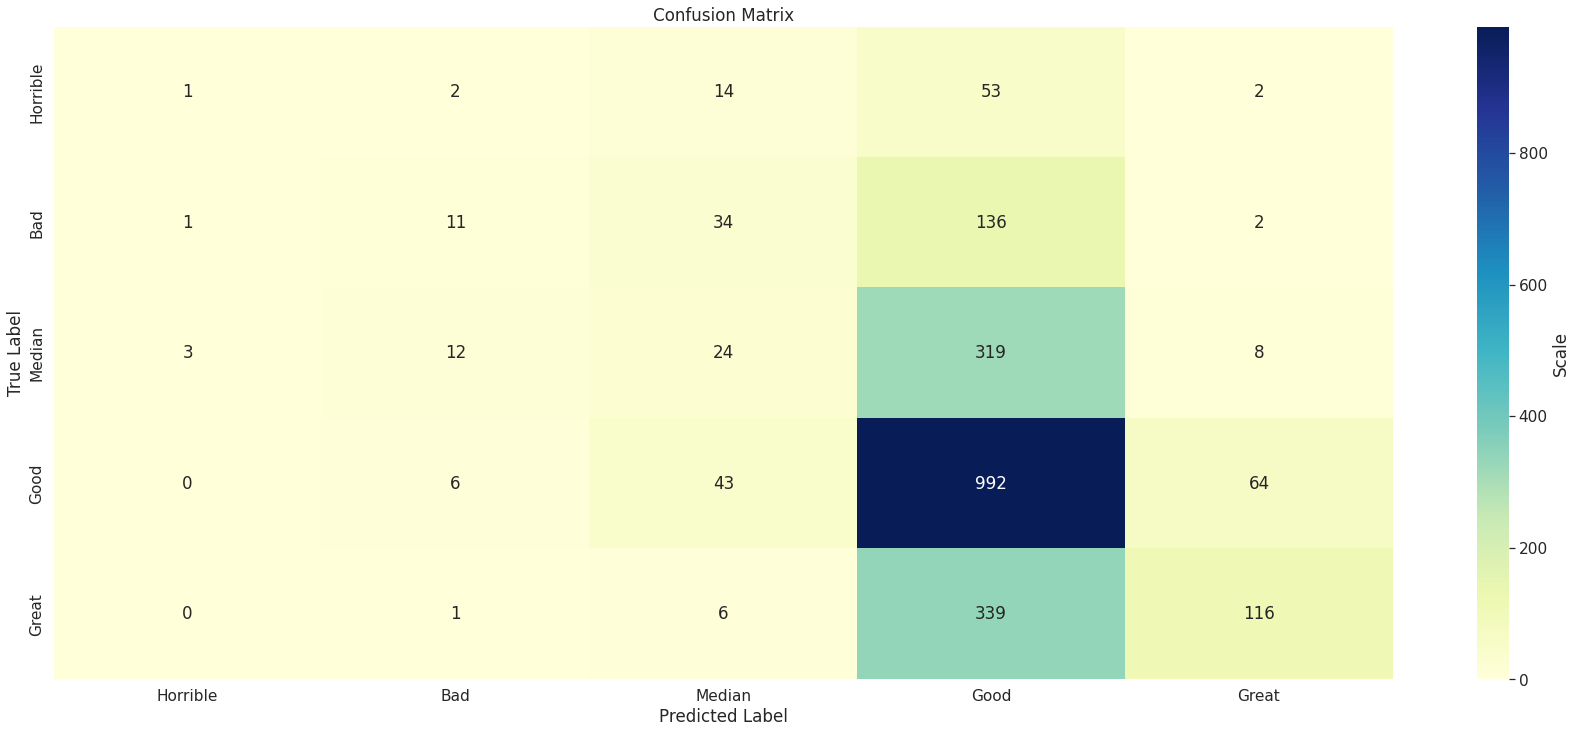

In [ ]:
sb.set(color_codes=True)
sb.set(font_scale=1.4)

plt.figure(1, figsize=(30, 12))
plt.title("Confusion Matrix")
conf_matrix = confusion_matrix(y_test, predict_test)
cm_df = pd.DataFrame(conf_matrix,
                     index = ['Horrible','Bad', 'Median', 'Good', 'Great'], 
                     columns = ['Horrible','Bad', 'Median', 'Good', 'Great'])
train = sb.heatmap(cm_df, annot=True, fmt=".0f",cmap="YlGnBu", cbar_kws={'label': 'Scale'})
train.set(ylabel="True Label", xlabel="Predicted Label")